In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import numpy as np
import pandas as pd
import cv2
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models
import torch.optim as optim
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
#nltk.download('punkt')
import ast
import pickle

from transform import *
from custom_data import ImageCaptionDataset

In [2]:
#data = pd.read_csv('data/results2.csv')
#data.dropna(inplace=True)
#data.to_csv('data/results2.csv', index=False)

```
def create_vocab_file(col_serie_pandas):
    data_vocab = col_serie_pandas.apply(lambda x: ' '.join(x))
    data_vocab = ' '.join(list(data_vocab))
    vocabulary = word_tokenize(data_vocab)

    words_tokens = set([i.lower() for i in vocabulary])
    token_map_integer = {}

    for n, i in enumerate(words_tokens):
        token_map_integer[i] = n

    token_map_integer['<start>'] = -400
    token_map_integer['<end>'] = -401
    
    return vocabulary, token_map_integer
```

```
f = open("mapping.pkl","wb")
pickle.dump(token_map_integer,f)
f.close()
```

```
with open('mapping.pkl', 'rb') as f:
    test = pickle.load(f)
```

In [3]:
batch_size = 10
num_workers = 4
csv_file = 'data/results2.csv'
root_dir = 'data/flickr30k_images'
mapper_file = 'mapping.pkl'

transform = transforms.Compose([
    Rescale(224),
    Normalize(),
    ToTensor()
])

In [4]:
valid_size = 0.3

def train_valid_split(training_set, validation_size):
    """ Function that split our dataset into train and validation
        given in parameter the training set and the % of sample for validation"""
    
    # obtain training indices that will be used for validation
    num_train = len(training_set)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(validation_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    return train_sampler, valid_sampler




train_set = ImageCaptionDataset(csv_file=csv_file,
                                root_dir=root_dir,
                                mapper_file=mapper_file,
                                transform=transform)

train_sampler, valid_sampler = train_valid_split(train_set, valid_size)


train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          sampler=train_sampler,
                          num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=num_workers)

Reading data...
Calculating length...
Reading Mapper file...
Ready !


tensor([20294,  5682,  3376, 13227, 12310,  5682, 19257,  6847, 13983, 19033,
         5682, 19773,  4843,  9926, 20295, 20296, 20296, 20296, 20296, 20296])
20


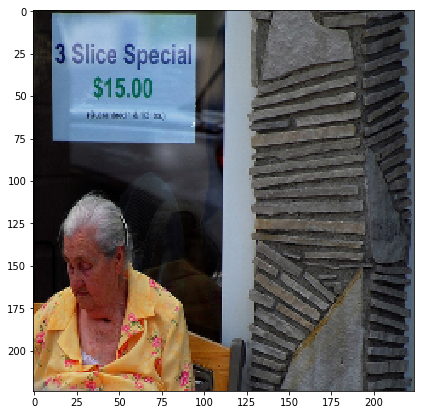

In [5]:
#```
plt.figure(figsize=(7,7))

# obtain one batch of training images
batch = next(iter(train_loader))

# display 10 images
for i in np.arange(1):
    
    images, labels = batch['image'], batch['caption']
    
    #unormalize images
    image = images[i].numpy()
    image = np.transpose(image, (1, 2, 0))
    
    labels = labels[i]
    
    #plt.subplot(5,1,i+1)
    plt.imshow(np.squeeze(image), cmap='gray')
    print(labels)
    print(len(labels))
#```

In [6]:
from models import EncoderCNN

batch = next(iter(train_loader))
images, captions = batch['image'], batch['caption']
             
images = images.type(torch.FloatTensor)
embed_size = 256

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA not available... Training on CPU')
else:
    print('CUDA available... Training on GPU')
    

# Initialize the encoder and decoder
encoder = EncoderCNN(embed_size)

features = encoder(images)

assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor." 
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."

CUDA not available... Training on CPU


In [7]:
from models import DecoderRNN

with open('mapping.pkl', 'rb') as f:
    vocab = pickle.load(f)

vocab_size = len(vocab)

hidden_size = 512

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

In [8]:
decoder

DecoderRNN(
  (word_embeddings): Embedding(20297, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=20297, bias=True)
)

In [10]:
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 21, 20297])


### Go to Google Colab for training